In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error


import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
# directory path for save checkpoint
dir1="./"

In [3]:
# Read in data and display first 5 rows
fn='./Concat_data.csv'
features1 = pd.read_csv(fn)

features=features1
features.head()



,Unnamed: 0,utvec,dv,temp,SM_EWT
0,0,2007.089722,-0.1144,-0.779977,0.045406
1,1,2007.092407,-0.1211,-0.778436,0.046900
2,2,2007.095093,-0.1260,-0.772052,0.048463
3,3,2007.097900,-0.1276,-0.756125,0.049956
4,4,2007.100586,-0.1357,-0.742824,0.051519


In [4]:
# Assuming you have three time series: dv, temperature, and soil moisture
dv = np.asarray(features.dv) 
dv = dv / np.max(np.abs(dv))

temperature = np.asarray(features.temp)
soil_moisture = np.asarray(features.SM_EWT)


(92934,) (92934,) (92934,)


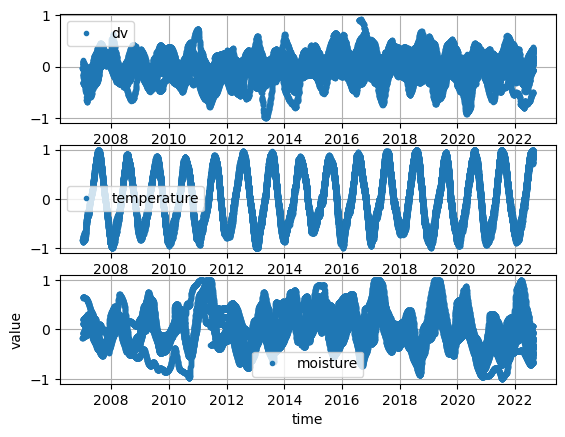

In [5]:
print(dv.shape, temperature.shape, soil_moisture.shape)
fig, ax = plt.subplots(3,1)
# Plot the true vs predicted soil moisture values
ax[0].plot(features.utvec, dv, label='dv', ls="", marker='.')
ax[1].plot(features.utvec, temperature, label='temperature', ls="", marker='.')
ax[2].plot(features.utvec, soil_moisture, label='moisture', ls="", marker='.')
plt.xlabel('time')
plt.ylabel('value')
ax[0].legend();ax[1].legend();ax[2].legend();
ax[0].grid(True);ax[1].grid(True);ax[2].grid(True);
plt.show()


In [6]:

# Combine input features (dv and temperature) into a single array
X = np.column_stack((dv, temperature))

# Standardize input features and target variable
scaler_X = StandardScaler()
X = scaler_X.fit_transform(X)

scaler_y = StandardScaler()
y = scaler_y.fit_transform(soil_moisture.reshape(-1, 1)).flatten()


In [7]:
select_test_size=0.25

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=select_test_size , random_state=28)

# Convert data to PyTorch tensors
X_train_tensor = torch.from_numpy(X_train).float()
y_train_tensor = torch.from_numpy(y_train).float()
X_test_tensor = torch.from_numpy(X_test).float()
y_test_tensor = torch.from_numpy(y_test).float()


In [8]:
select_batch_size=128
# Inverse transform to get back the original scale of soil moisture for training set
y_train_inverse = scaler_y.inverse_transform(y_train.reshape(-1, 1)).flatten()

# Create DataLoader
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=select_batch_size , shuffle=True)


In [9]:
# Normalize input data
#scaler_X = StandardScaler()
#X_train = scaler_X.fit_transform(X_train)
#X_test = scaler_X.transform(X_test)

In [10]:

# Define the neural network model
class SimpleNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(input_size, 4)
        self.fc2 = nn.Linear(4, 16)
        self.fc3 = nn.Linear(16, hidden_size)
        self.fc4 = nn.Linear(hidden_size, 16)
        self.fc5 = nn.Linear(16,4)
        self.fc6 = nn.Linear(4,output_size)
        self.relu = nn.ReLU()  # Adding ReLU activation
        
    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.relu(x)  # You can add ReLU here if you want
        x = self.fc3(x)
        x = self.relu(x)
        x = self.fc4(x)
        x = self.relu(x)
        x = self.fc5(x)
        x = self.relu(x)
        x = self.fc6(x)
        return x

In [11]:
class EarlyStopping:
    def __init__(self, patience=5, delta=0, verbose=False):
        self.patience = patience
        self.delta = delta
        self.verbose = verbose
        self.counter = 0
        self.best_loss = None
        self.early_stop = False

    def __call__(self, val_loss):
        if self.best_loss is None:
            self.best_loss = val_loss
        elif val_loss > self.best_loss + self.delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_loss = val_loss
            self.counter = 0

        if self.verbose:
            print(f'Early Stopping Counter: {self.counter}/{self.patience}')

        return self.early_stop


Epoch 1/60 | Train Loss: 0.1455 | Test Loss: 0.1389
Epoch 2/60 | Train Loss: 0.1438 | Test Loss: 0.1386
Epoch 3/60 | Train Loss: 0.1426 | Test Loss: 0.1385
Epoch 4/60 | Train Loss: 0.1416 | Test Loss: 0.1383
Epoch 5/60 | Train Loss: 0.1408 | Test Loss: 0.1382
Epoch 6/60 | Train Loss: 0.1401 | Test Loss: 0.1381
Epoch 7/60 | Train Loss: 0.1396 | Test Loss: 0.1380
Epoch 8/60 | Train Loss: 0.1392 | Test Loss: 0.1380
Epoch 9/60 | Train Loss: 0.1389 | Test Loss: 0.1379
Epoch 10/60 | Train Loss: 0.1387 | Test Loss: 0.1379
Epoch 11/60 | Train Loss: 0.1385 | Test Loss: 0.1379
Epoch 12/60 | Train Loss: 0.1383 | Test Loss: 0.1378
Epoch 13/60 | Train Loss: 0.1382 | Test Loss: 0.1378
Epoch 14/60 | Train Loss: 0.1381 | Test Loss: 0.1378
Epoch 15/60 | Train Loss: 0.1380 | Test Loss: 0.1378
Epoch 16/60 | Train Loss: 0.1379 | Test Loss: 0.1378
Epoch 17/60 | Train Loss: 0.1378 | Test Loss: 0.1378
Epoch 18/60 | Train Loss: 0.1378 | Test Loss: 0.1377
Epoch 19/60 | Train Loss: 0.1377 | Test Loss: 0.1377
Ep

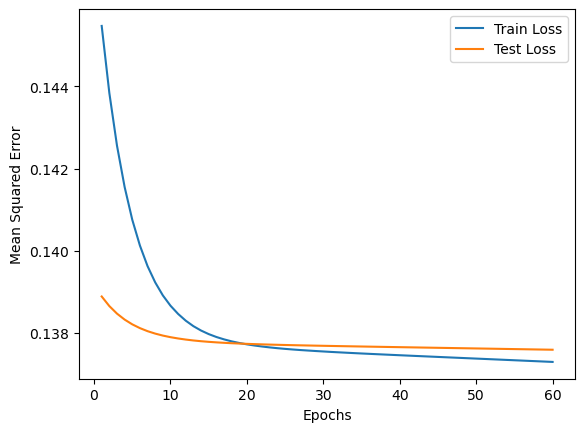

In [12]:

# Instantiate the model
input_size = X.shape[1]
hidden_size = 32
output_size = 1
model = SimpleNN(input_size, hidden_size, output_size)

# Loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.SGD(model.parameters(), lr=0.0001)

## Learning rate schedule
#scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=10, factor=0.1, verbose=True)

# Early stopping
#early_stopping = EarlyStopping(verbose=True)

# Lists to store training history
train_loss_history = []
test_loss_history = []
# Lists to store iteration or epoch numbers
epochs_list = []


# Training loop
num_epochs = 60
for epoch in range(num_epochs):
    model.train()  # Set the model to training mode
    for inputs, targets in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs.squeeze(), targets)
        loss.backward()
        optimizer.step()

    # Evaluate on the test set
    model.eval()  # Set the model to evaluation mode
    with torch.no_grad():
        y_pred_tensor = model(X_test_tensor)
    y_pred = y_pred_tensor.numpy()

    # Inverse transform to get back the original scale of soil moisture
    y_test_inverse = scaler_y.inverse_transform(y_test.reshape(-1, 1)).flatten()
    y_pred_inverse = scaler_y.inverse_transform(y_pred.reshape(-1, 1)).flatten()

    # Calculate and log the Mean Squared Erro (or rmean_absolute_error) on the training and test sets
    train_loss = mean_squared_error(y_train_inverse, model(X_train_tensor).detach().numpy().flatten())
    test_loss = mean_squared_error(y_test_inverse, y_pred_inverse)

    train_loss_history.append(train_loss)
    test_loss_history.append(test_loss)
    epochs_list.append(epoch + 1)

    print(f'Epoch {epoch + 1}/{num_epochs} | Train Loss: {train_loss:.4f} | Test Loss: {test_loss:.4f}')

    checkpoint = {
        'epoch': epoch + 1,
        'state_dict': model.state_dict(),
        'optimizer': optimizer.state_dict()
                    }

    f_path = dir1+'/checkpoint.pt'
    torch.save(checkpoint, f_path)
    
        
# Plot the loss over epochs
plt.plot(epochs_list, train_loss_history, label='Train Loss')
plt.plot(epochs_list, test_loss_history, label='Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Mean Squared Error')
plt.legend()
plt.show()

In [13]:

# Evaluation on the test set
model.eval()
with torch.no_grad():
    y_pred_tensor = model(X_test_tensor)
y_pred = y_pred_tensor.numpy()

# Inverse transform to get back the original scale of soil moisture
y_test_inverse = scaler_y.inverse_transform(y_test.reshape(-1, 1)).flatten()
y_pred_inverse = scaler_y.inverse_transform(y_pred.reshape(-1, 1)).flatten()

# Calculate and print the Mean Squared Error on the test set
mse = mean_squared_error(y_test_inverse, y_pred_inverse)
print(f'Mean Squared Error on Test Set: {mse:.4f}')

mae = mean_absolute_error(y_test_inverse, y_pred_inverse)
print(f'Mean Absolute Error on Test Set: {mae:.4f}')




Mean Squared Error on Test Set: 0.1376
Mean Absolute Error on Test Set: 0.2974


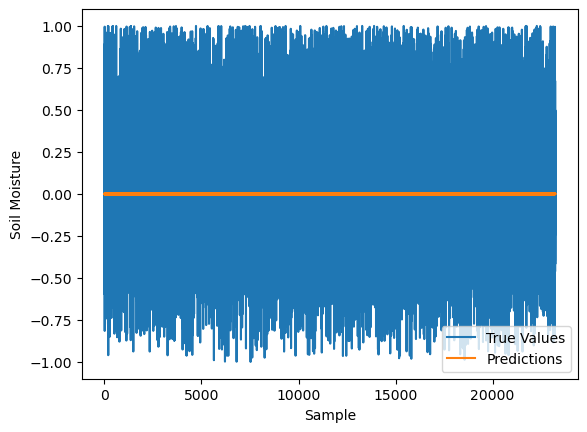

In [14]:

# Plot the true vs predicted soil moisture values
plt.plot(y_test_inverse, label='True Values')
plt.plot(y_pred_inverse, label='Predictions')
plt.xlabel('Sample')
plt.ylabel('Soil Moisture')
plt.legend()
plt.show()

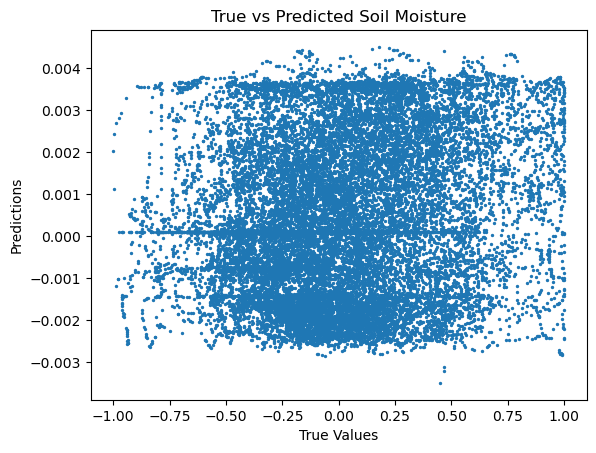

In [15]:
#plt.ylim(-1,1)
#plt.xlim(-1,1)
#
plt.scatter(y_test_inverse, y_pred_inverse, s=2, )
#plt.plot([-1,1],[-1,1],ls='--', c='grey')

plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.title('True vs Predicted Soil Moisture')
plt.show()


In [16]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

mse = mean_squared_error(y_test_inverse, y_pred_inverse)
print(f'Mean Squared Error: {mse:.4f}')

rmse = np.sqrt(mse)
print(f'Root Mean Squared Error:  {rmse:.4f}')

mae = mean_absolute_error(y_test_inverse, y_pred_inverse)
print(f'Mean Absolute Error:  {mae:.4f}')

r2 = r2_score(y_test_inverse, y_pred_inverse)
print(f'R-squared: {r2:.4f}')


Mean Squared Error: 0.1376
Root Mean Squared Error:  0.3709
Mean Absolute Error:  0.2974
R-squared: 0.0017
